# LFP dataset example

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as clr

import random
# Initialize the random seed to ensure reproducibility of the results in the paper
random.seed(10)

import jax.numpy as jnp
from src.featlin import Featlin
from src.featlin import jax_moment

from src.basis import BasicsData

plt.style.use('./styles/plots.mplstyle')

%load_ext autoreload
%autoreload 2

In [2]:
save_plots = 0
save_path = './results/Linearization/'

In [3]:
# Colorblind safe palette from: https://gka.github.io/palettes/#/26|s|00429d,96ffea,ffffe0|ffffe0,ff005e,93003a|1|1 
# IBM Colors: https://www.ibm.com/design/language/color/
# https://lospec.com/palette-list/ibm-color-blind-safe

colors = ['#332bb3', '#4a31b5', '#5d37b6', '#6d3db7', '#7c43b7', '#8a49b6', '#964fb5', '#a256b3', '#ad5db1', '#b764b0', '#c16cae', '#ca75ad', '#d27eac', '#d989ab', '#e094aa', '#e7a1ab', '#ecafac', '#f0beae', '#f4cfb0', '#f6e1b4']
colors_IBM = ['#648fff', '#785ef0', '#dc267f', '#fe6100', '#ffb000',  '#000000']
cmap_ = clr.LinearSegmentedColormap.from_list('Blue-light cb-safe', colors, N=256)
cmap = clr.LinearSegmentedColormap.from_list('Blue-light cb-IBM', colors_IBM[:-1], N=256)
color_list = [colors_IBM[0], colors_IBM[2], colors_IBM[3], colors_IBM[4], colors_IBM[5]]
marker_list = ['s', 'o', 'D', 'P']

In [4]:
# Load the LFP Dataset
lfp_df = pd.read_csv('./data/lfp_slim.csv', index_col=0)

X_lfp = np.array(lfp_df.iloc[:, 0:1000])
X_lfp = X_lfp[:, ::-1]
y_lfp_true = np.array(lfp_df.iloc[:, 1000])
x_lfp = np.linspace(2.0, 3.5, 1000)

X_lfp_train = np.array(X_lfp[lfp_df.iloc[:, 1002]==0, :])
y_lfp_train_true = np.array(y_lfp_true[lfp_df.iloc[:, 1002]==0])
X_lfp_test = np.array(X_lfp[lfp_df.iloc[:, 1002]==1, :])
y_lfp_test_true = np.array(y_lfp_true[lfp_df.iloc[:, 1002]==1])
X_lfp_test2 = np.array(X_lfp[lfp_df.iloc[:, 1002]==2, :])
y_lfp_test2_true = np.array(y_lfp_true[lfp_df.iloc[:, 1002]==2])

labels_lfp = {'xdata_label': 'Voltage (V)', 'ydata_label': r'$\Delta \mathbf{Q}_{100\mathrm{-}10}$ (Ah)', 'row_label': 'Battery number'}

In [5]:
# Remove outlier 
id_outlier = np.where(np.mean(X_lfp_train, axis=1)==np.min(np.mean(X_lfp_train, axis=1)))
X_lfp_train = np.delete(X_lfp_train, id_outlier, axis=0)
y_lfp_train_true = np.delete(y_lfp_train_true, id_outlier, axis=0)

# Ground Truth Features
- Mean 
- Varinace
- Sum of Squares
- Skewness


In [6]:
# True underlying relationship between the measurements and some quantity we ewould like to recover/predict from measurements

# JAX numpy wrapper target function  to allow for autodifferentiation
fun_targetj = [
    lambda a : jnp.mean(a),
    lambda a : jnp.sum(a**2),
    lambda a : jnp.var(a),
    lambda x: jax_moment(x,3)/((jax_moment(x,2))**(3/2)),
    lambda x: jax_moment(x,4)/(jax_moment(x,2)**2)-3
    ]
fun_target_names = [
    'Sum',
    'Sum of Squares',
    'Variance', 
    'Skewness',
    'Kurtosis',
    ]
feat_fun_dict = {fun_target_names[i] : fun_targetj[i] for i in range(len(fun_targetj))}

# What if the relationship is actually a combination fo different functions
# Combinations based of the functions above to obtain non-linear functions of different complexity
# This is expected to show limits of the methodology
fun_target_combj = [
    lambda  a : np.array(5*fun_targetj[0](a) + fun_targetj[1](a)),
    lambda  a : np.array(3*fun_targetj[2](a) + fun_targetj[0](a)),
    lambda  a : np.array(fun_targetj[1](a) * fun_targetj[3](a)),
    lambda  a : np.array(fun_targetj[3](a) * fun_targetj[4](a))
    ]
ftarget_comb_names = [
    '5*\sum_{i=1}^n x_i + \sum_{i=1}^n x_i^2',
    '3*\text{var}(\mathbf{x}) + \sum_{i=1}^n x_i',
    '\sum_{i=1}^n x_i^2 * \text{skewness}(\mathbf{x})',
    '\text{skewneww}(\mathbf{x}) * \text{kurtosis}(\mathbf{x})'
]

# X = X_lfp_train-np.mean(X_lfp, axis=0)
# y_gt = np.zeros([X.shape[0], 5, 1])
# for j in range(len(fun_targetj)): 
#     y_gt[:, j, 0] = generate_target_values(X[:, :], fun_targetj[j], percentage_range_x_to_t=[0,1], snr=50)

In [7]:
# Generate BasicsData class objects
lfp_mean = BasicsData(X=X_lfp_train, x=x_lfp, y=None) 
lfp_mean = lfp_mean.construct_y_data(fun_targetj[0]).add_wgn(add_noise_X=False, add_noise_y=True, snr_y=50)

# Mean
lfp_mean = BasicsData(X=X_lfp_train, x=x_lfp, y=None) 
lfp_mean = lfp_mean.construct_y_data(fun_targetj[0]).add_wgn(add_noise_X=False, add_noise_y=True, snr_y=50)

# Sum Squares
lfp_sums = BasicsData(X=X_lfp_train, x=x_lfp, y=None) 
lfp_sums = lfp_sums.construct_y_data(fun_targetj[1]).add_wgn(add_noise_X=False, add_noise_y=True, snr_y=50)

# Variance
lfp_var = BasicsData(X=X_lfp_train, x=x_lfp, y=None) 
lfp_var = lfp_var.construct_y_data(fun_targetj[2]).add_wgn(add_noise_X=False, add_noise_y=True, snr_y=50)

# Skew
lfp_skew = BasicsData(X=X_lfp_train, x=x_lfp, y=None) 
lfp_lfp_skewvar = lfp_skew.construct_y_data(fun_targetj[3]).add_wgn(add_noise_X=False, add_noise_y=True, snr_y=50)

# Kurt
lfp_kurt = BasicsData(X=X_lfp_train, x=x_lfp, y=None) 
lfp_kurt = lfp_kurt.construct_y_data(fun_targetj[4]).add_wgn(add_noise_X=False, add_noise_y=True, snr_y=50)

# Log Cycle Life
lfp_lcl = BasicsData(X=X_lfp_train, x=x_lfp, y=np.log(y_lfp_train_true))

In [8]:
# Inititate the class with data (x, y) & features that you want to test
if 0: 
    opt_dist = {'active':False, 'model':'ridge', 'norm':2}
    lfp_meangt = Featlin(data_obj=lfp_mean, feat_funcs=feat_fun_dict)
    lfp_meangt = lfp_meangt.analyze_all_features(max_nrmse=0.1, opt_dist=opt_dist, opt_nrmse=1)

In [9]:
# Inititate the class with data (x, y) & features that you want to test
if 0: 
    opt_dist = {'active':False, 'model':'ridge', 'norm':1}
    lfp_sums_gt = Featlin(data_obj=lfp_sums, feat_funcs=feat_fun_dict)
    # Run the tests
    lfp_sums_gt = lfp_sums_gt.analyze_all_features(max_nrmse=0.1, opt_dist=opt_dist, opt_nrmse=1)
    plt.show()

In [10]:
if 0:     
    # Inititate the class with data (x, y) & features that you want to test
    opt_dist = {'active':False, 'model':'PLS', 'norm':2}
    opt_nrmse = {'active':True, 'model':'PLS', 'norm':2, 'max_comp':15}
    fig_props = {'save':True, 'ax0_xlabel':'Voltage (V)', 'save_path':'./results/VariancePLS', 'response':'',
                'multiple_fig':True}#'response':'Groundtruth Response: Variance'}

    lfp_var_gt = Featlin(data_obj=lfp_var, feat_funcs=feat_fun_dict)

    # Run the tests
    lfp_var_gt = lfp_var_gt.analyze_all_features(max_nrmse=0.05, opt_dist=opt_dist, opt_nrmse=opt_nrmse, fig_props=fig_props)
    plt.show()

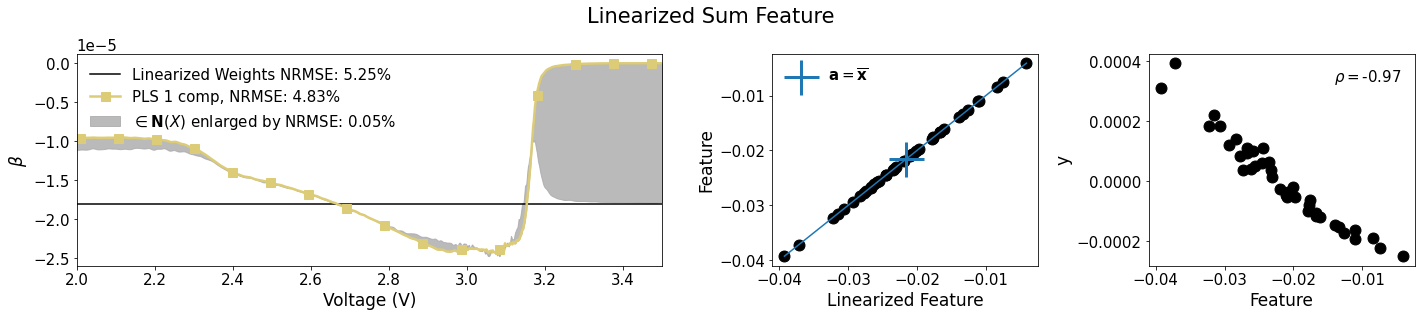

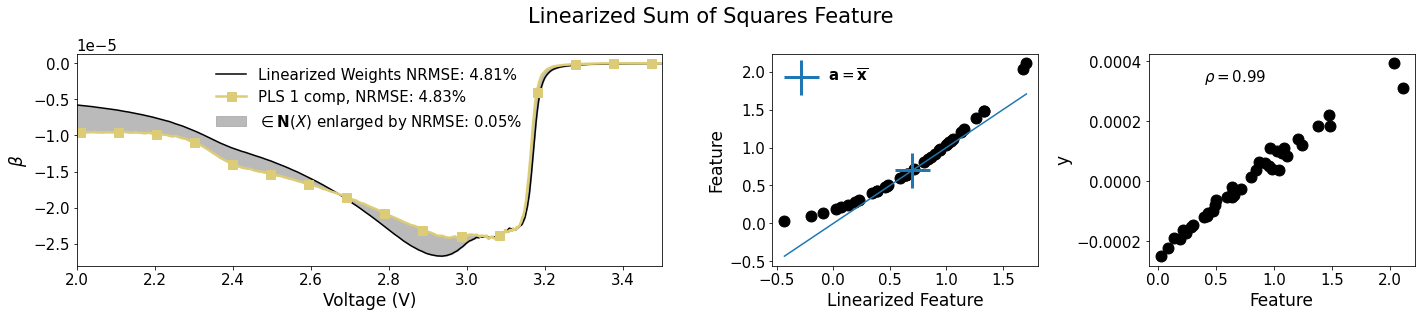

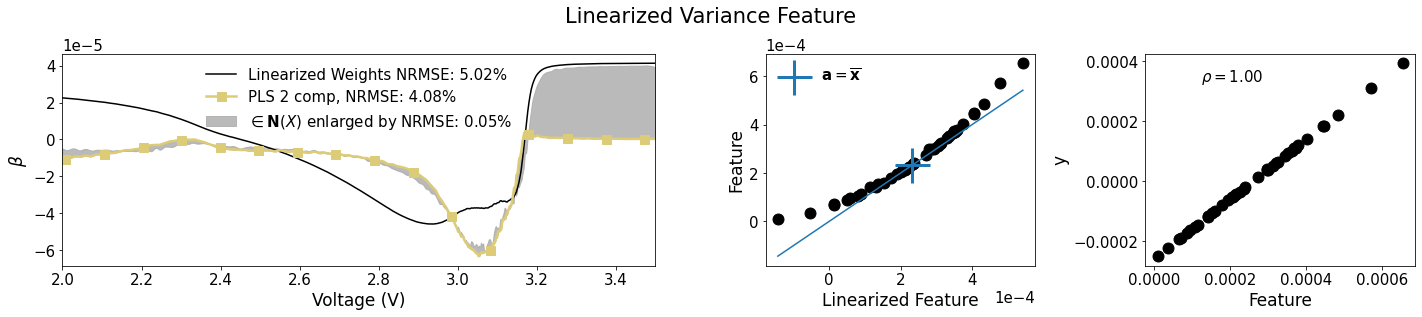

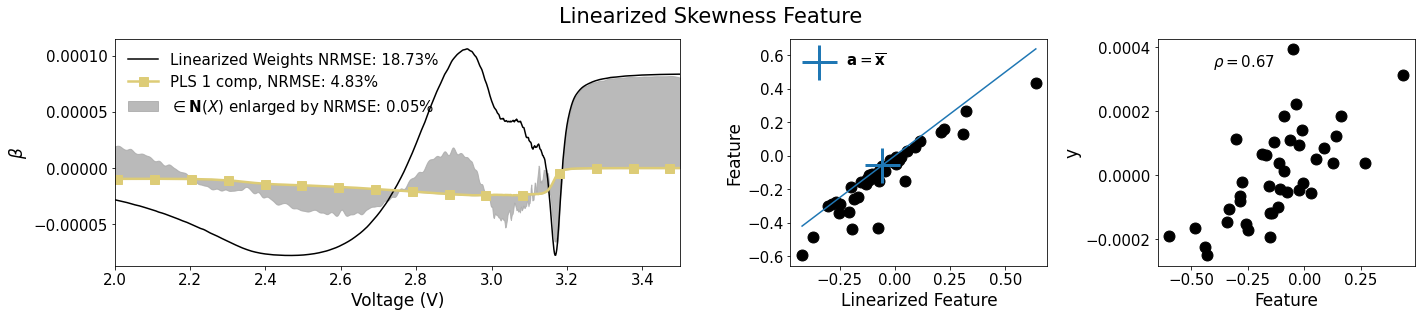

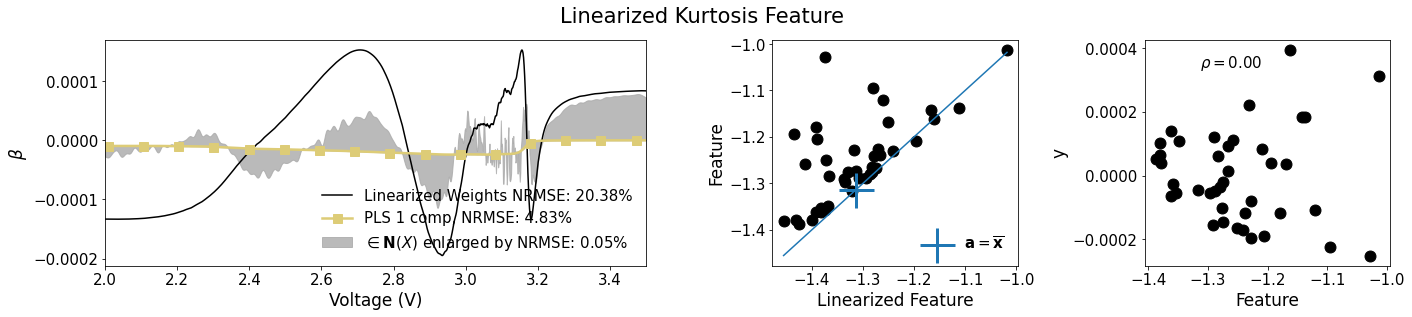

In [11]:
# Inititate the class with data (x, y) & features that you want to test
opt_dist = {'active':False, 'model':'PLS', 'norm':2}
opt_nrmse = {'active':True, 'model':'PLS', 'norm':2, 'max_comp':15}
fig_props = {'save':True, 'ax0_xlabel':'Voltage (V)', 'save_path':'./results/VariancePLS', 'response':'',
             'multiple_fig':True, 'response':'Groundtruth Response: Variance'}

lfp_var_gt = Featlin(data_obj=lfp_var, feat_funcs=feat_fun_dict)

# Run the tests
lfp_var_gt = lfp_var_gt.analyze_all_features(
    opt_cv={'active':True, 'model': []}, 
    opt_dist={'active':True, 'model': ['PLS']}, 
    fig_props = fig_props, max_nrmse=0.05)

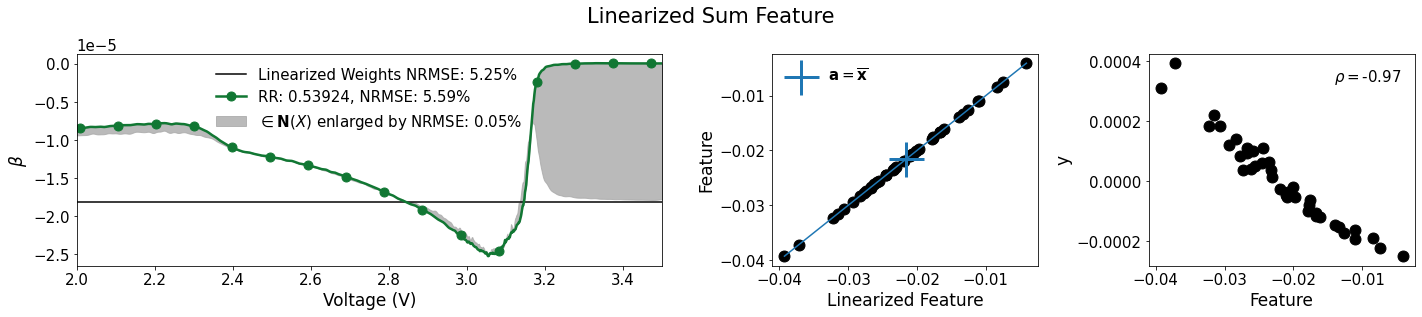

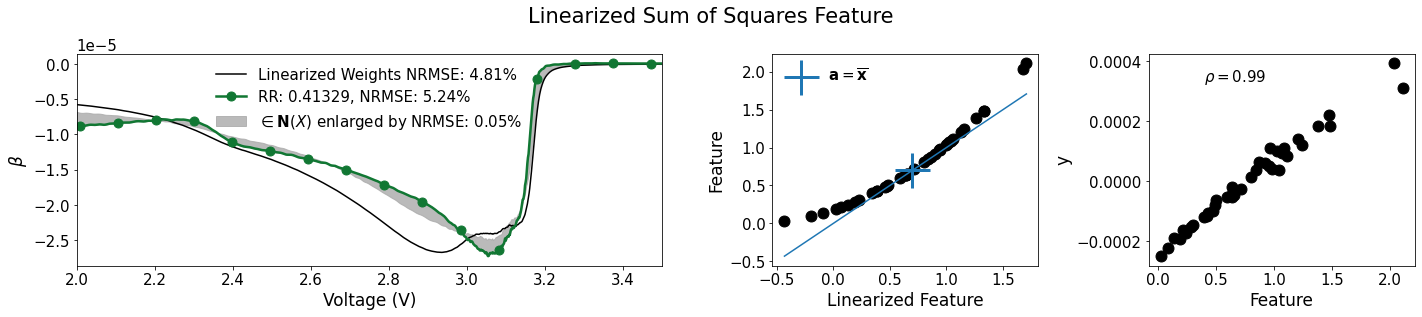

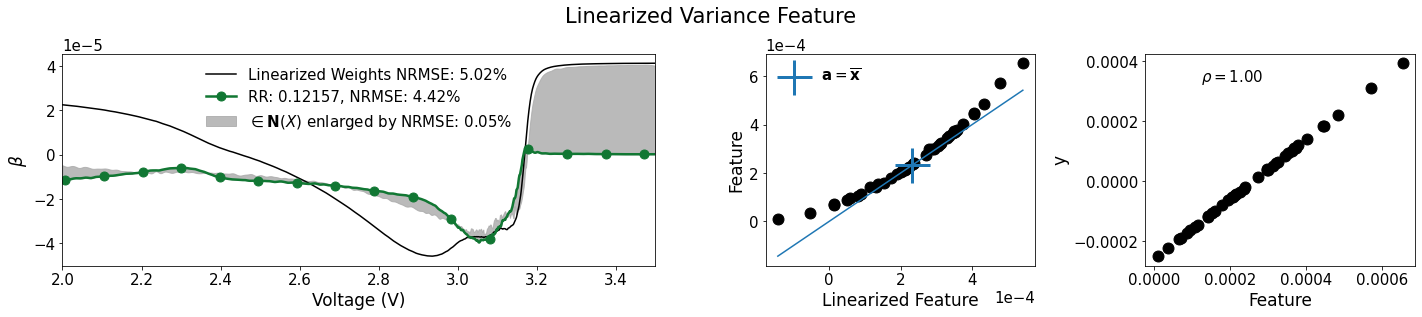

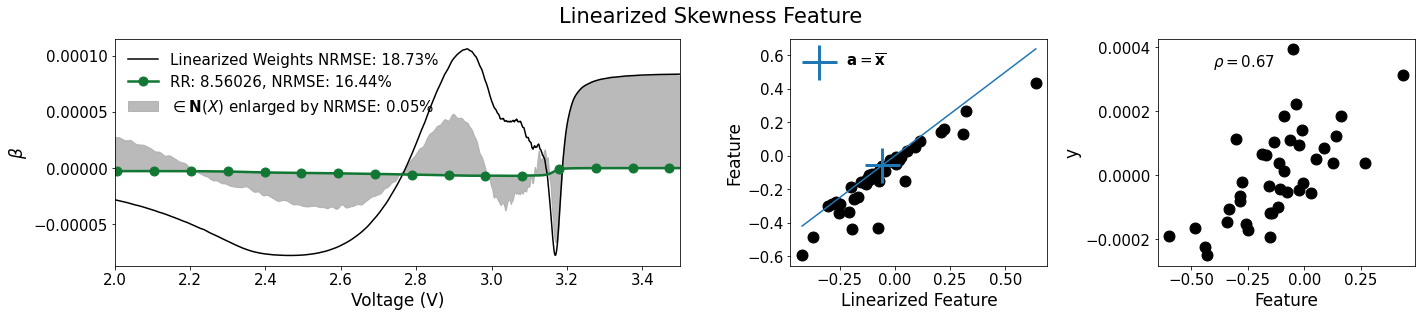

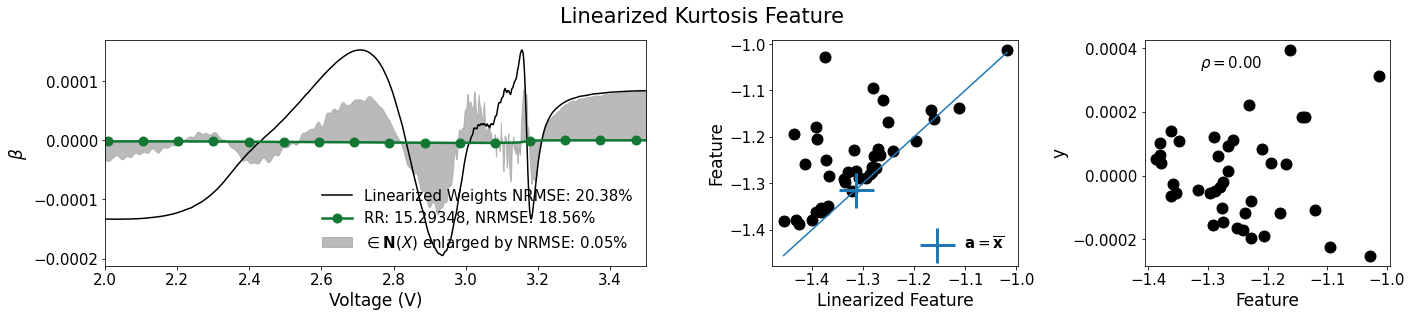

In [12]:
# Inititate the class with data (x, y) & features that you want to test
fig_props = {'save':True, 'ax0_xlabel':'Voltage (V)', 'save_path':'./results/VarianceRR', 'response':'',
            'multiple_fig':True}

lfp_var_gt = Featlin(data_obj=lfp_var, feat_funcs=feat_fun_dict)

# Run the tests
lfp_var_gt = lfp_var_gt.analyze_all_features(
    opt_cv={'active':True, 'model': []}, 
    opt_dist={'active':True, 'model': ['RR']}, 
    fig_props = fig_props, max_nrmse=0.05)
plt.show()

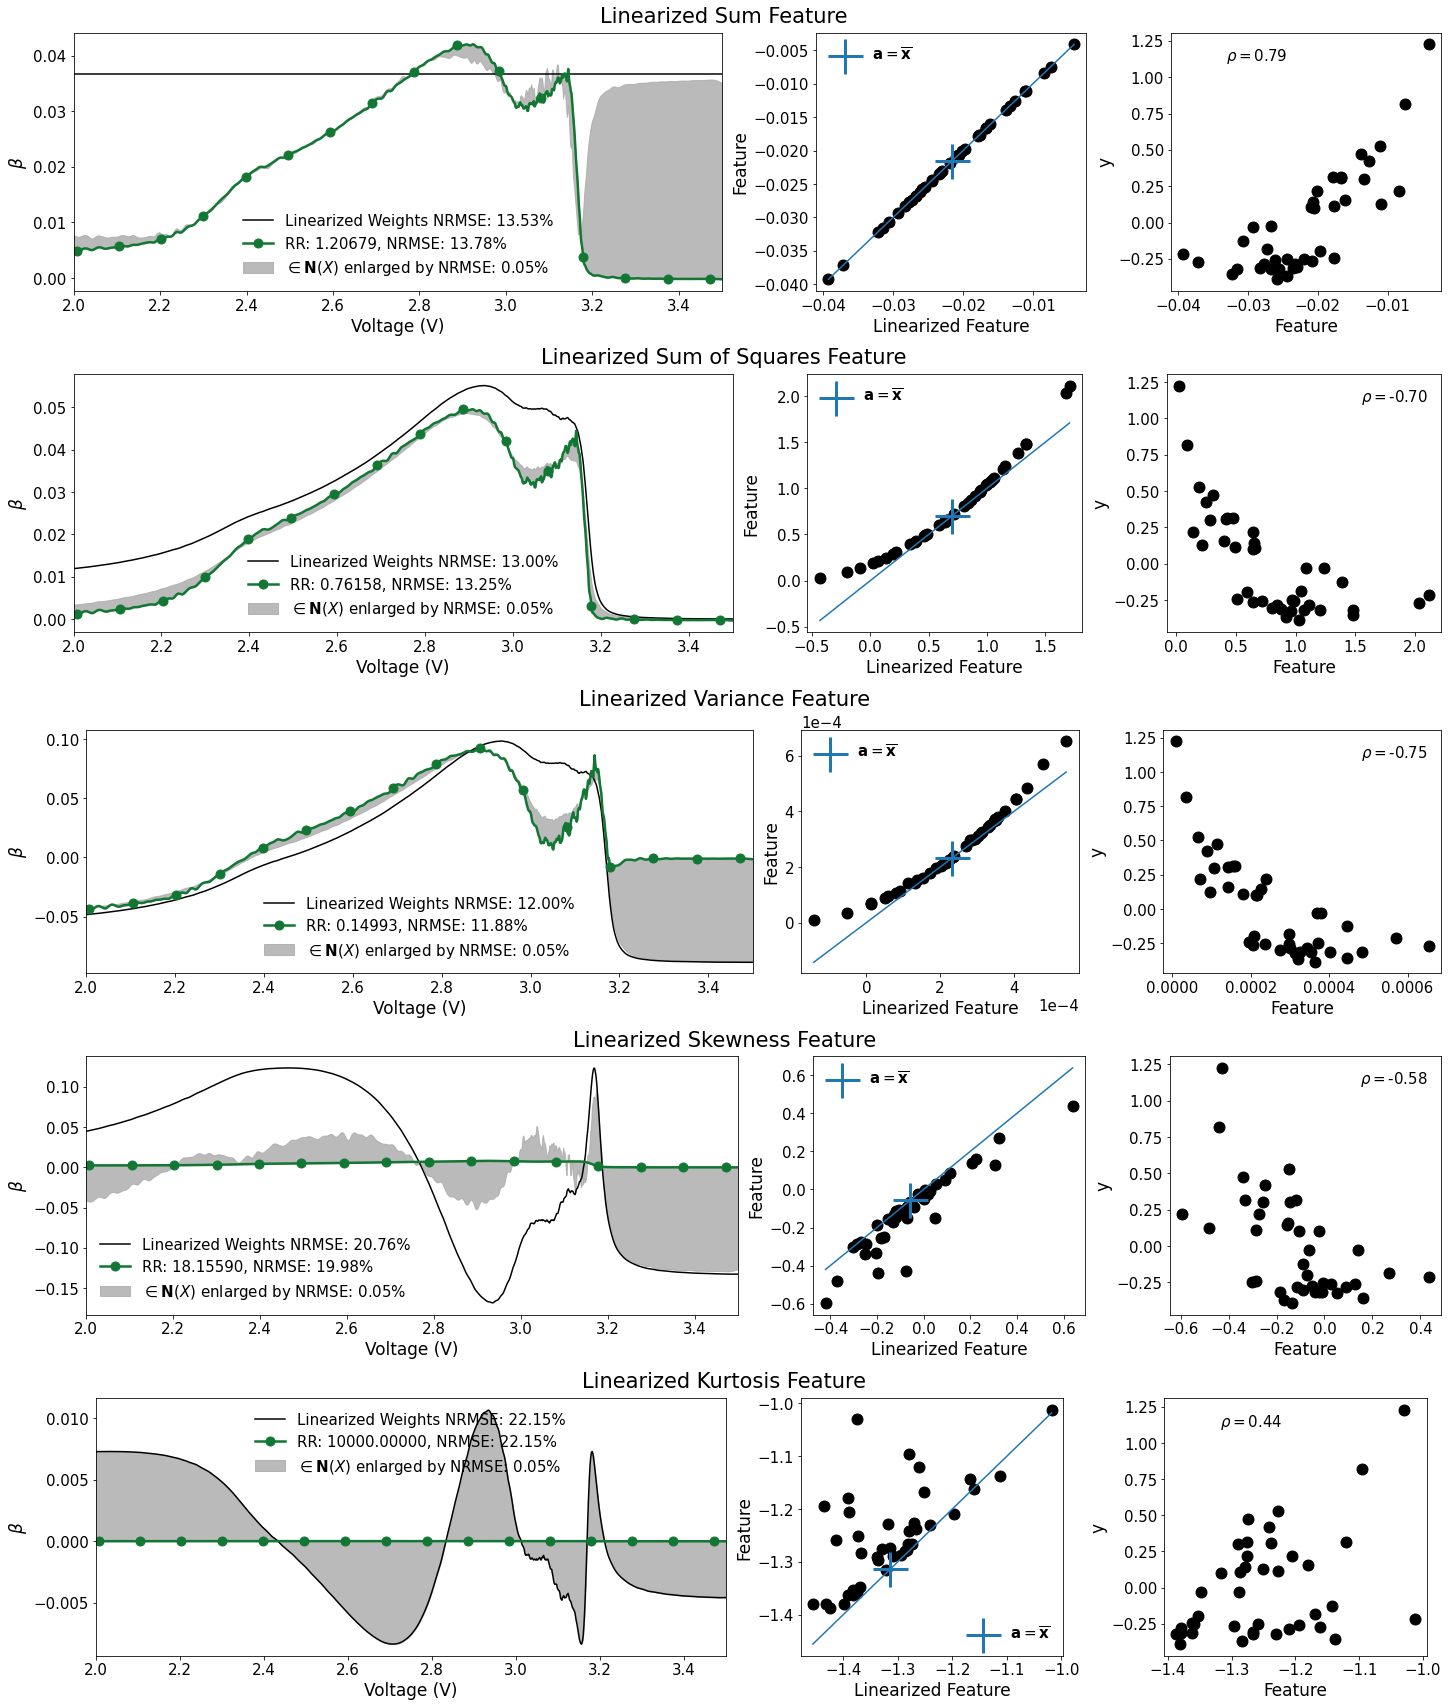

In [13]:
# Inititate the class with data (x, y) & features that you want to test
fig_props = {'save':False, 'ax0_xlabel':'Voltage (V)', 'save_path':'./results/LCL_PLS', 'response':'',
            'multiple_fig':False}

fl_lfp_lcl = Featlin(data_obj=lfp_lcl, feat_funcs=feat_fun_dict)

# Run the tests
fl_lfp_lcl = fl_lfp_lcl.analyze_all_features(
    opt_cv={'active':True, 'model': []}, 
    opt_dist={'active':True, 'model': ['RR']}, 
    fig_props = fig_props, max_nrmse=0.05)
plt.show()